In [46]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit.circuit.library import XGate, ZGate
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

In [71]:
num_input = 3
num_qubits = num_input * 2

In [72]:
def multi_cx(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    
    new_gate = XGate().control(num_controls, ctrl_state=ctrl_state)
    
    qc.append(new_gate, controls + anti_controls + [target])
    
    return qc

In [73]:
def multi_cz(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    new_gate = ZGate().control(num_controls, ctrl_state=ctrl_state)
    
    qc.append(new_gate, controls + anti_controls + [target])
    
    return qc

In [74]:
def get_ctrl_state(controls, anti_controls):
    # num_controls = len(controls) + len(anti_controls)
    ctrl_state = ''
    for i in range(num_qubits - 1, -1, -1):
        if i in controls:
            ctrl_state += '1'
        elif i in anti_controls:
            ctrl_state += '0'
    return ctrl_state

In [156]:
def szegedy_step(qc):
    multi_cx(qc, [2], [num_input + 1, num_input + 2], num_input + 0)
    multi_cx(qc, [2], [num_input + 2], num_input + 1)
    qc.cx(2, num_input + 2)

    multi_cx(qc, [1], [num_input + 1], num_input + 0)
    qc.cx(1, num_input + 1)

    qc.cx(0, num_input + 0)

    multi_cx(qc, [], [num_input + 0], num_input + 1)
    qc.h(num_input + 0)
    multi_cz(qc, [num_input + 0], [num_input + 1], num_input + 2)
    qc.h(num_input + 0)
    multi_cx(qc, [], [num_input + 0], num_input + 1)

    multi_cx(qc, [2, num_input + 1, num_input + 2], [], num_input + 0)
    multi_cx(qc, [2, num_input + 2], [], num_input + 1)
    qc.cx(2, num_input + 2)

    multi_cx(qc, [1, num_input + 1], [], num_input + 0)
    multi_cx(qc, [1], [], num_input + 1)
    qc.cx(0, num_input + 0)

    qc.swap(2, num_input + 2)
    qc.swap(1, num_input + 1)
    qc.swap(0, num_input + 0)
    
    # qc.draw(output="latex_source", filename="qcircuit.tex")
    qc.draw(output="mpl")

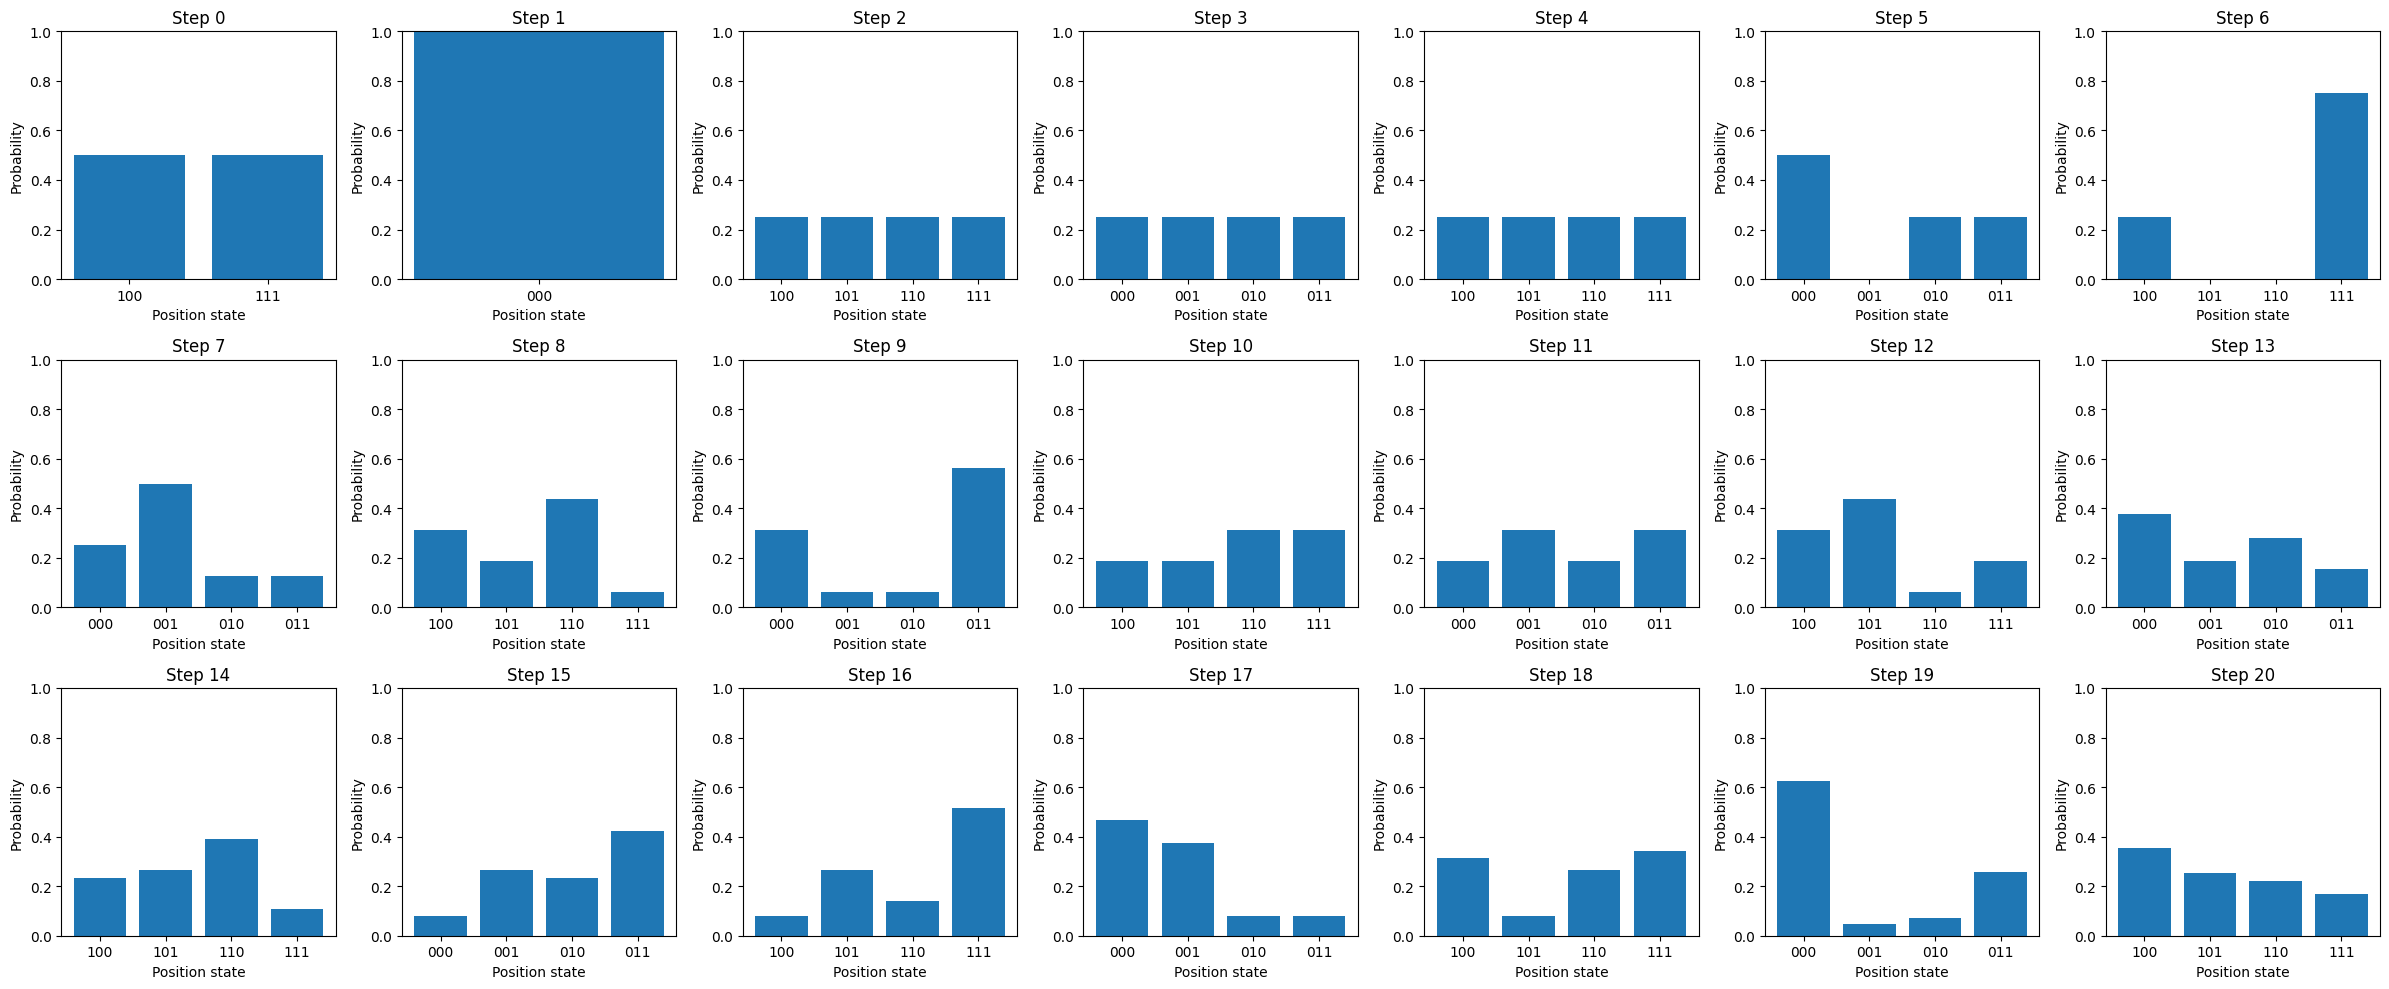

In [169]:
# Create the quantum circuit
qc = QuantumCircuit(num_input * 2, num_input * 2)

simulator = AerSimulator()

steps = 20
results = []

# Apply Hadamard coin operator
qc.h(num_input + 0)
qc.x(num_input + 2)
qc.cx(num_input + 0, num_input + 1)
# done with initail setup
qc.barrier()

states = [Statevector.from_instruction(qc)]
for _ in range(steps):
    qc.h(num_input + 0)
    szegedy_step(qc)
    qc.barrier()
    states.append(Statevector.from_instruction(qc))


fig, axs = plt.subplots(3, 7, figsize=(24, 10))
axs = axs.flatten()
for i, state in enumerate(states):
    probs = state.probabilities_dict()
    filtered = {}
    for key, val in probs.items():
        pos = key[:num_input]
        filtered[pos] = filtered.get(pos, 0) + val
    axs[i].bar(filtered.keys(), filtered.values())
    axs[i].set_title(f"Step {i}")
    axs[i].set_ylim(0, 1)
    axs[i].set_xlabel("Position state")
    axs[i].set_ylabel("Probability")

plt.tight_layout()
plt.show()

# qc.draw(output="mpl")



In [158]:

# Simulate the circuit
# simulator = Aer.get_backend("qasm_simulator")

qc = transpile(qc, simulator)
result = simulator.run(qc, shots=1024).result()
counts = result.get_counts(qc)

print("Measurement outcomes:", counts)
plot_histogram(counts, title='res')




    qc_current = qc.copy()
    qc_current.measure(range(num_input), range(num_input))
    t_qc = transpile(qc_current, simulator)
    result = simulator.run(t_qc, shots=1024).result().get_counts()
    results.append(result)

IndentationError: unexpected indent (3981868414.py, line 14)